The quality of music is something that is difficult to evaluate, usually people look at kbps of the song to decide on the quality but faking softawares found a way to trick kbps check. Good quality of the song is considered 320+kbps and anything less 320kbps is bad quality.The only way to actually know if you are dealing with good quality is to look at spectogram.
<br>
<br>
But what if I want to check my whole library if its any good or not? It will be rather difficult to do it manually, because usually its more than 10.000 in one folder.
<br>
<br>
So in this project I will distinguish between good quality music and bad music that tries to look as a good one with using CNN

<i>But what is spectogram ?</i><br>
A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time(wikipedia). Basically spectogram is the complex way to visualize audio, and it tells frequency of the sound with time, higher frequency leads to better quality, so in general 128 kbps is below 20khz and 320 kbps is 20khz and higher

<h3>Part 1: Getting spectogram from audio Files

Script below I used a script I wrote locally(you can find it in create_specs.py file) to get spectograms from the songs. To augment data and get more spectograms from the song I splitted the song into constant parts (around 25 seconds) and made a spectogram based on them. All songs had sample rate of 44100 from different genres of modern music. I made some cleaning in data as I was generating spectograms, because not all of them were valid about quality

<h3>Part 2: Loading and and Data Preparation

In [5]:
#libraries
import os
from random import randrange

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import utils
from torch import nn
import torch
from torchvision.models import vgg16, resnet18, resnet50
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

In [6]:
#folders with classes
os.listdir('/kaggle/input/spec-dataset-v2/spec_dataset/')

['specs_320', 'specs_128']

In [7]:
#func to get full path to the file
def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

In [8]:
#128
train_bad = pd.DataFrame({'img':list_full_paths('/kaggle/input/spec-dataset-v2/spec_dataset/specs_128/'),
                           'label':[0]*len(os.listdir('/kaggle/input/spec-dataset-v2/spec_dataset/specs_128/'))})
                           
#320                           
train_good = pd.DataFrame({'img':list_full_paths('/kaggle/input/spec-dataset-v2/spec_dataset/specs_320/'),
                           'label':[1]*len(os.listdir('/kaggle/input/spec-dataset-v2/spec_dataset/specs_320/'))})

In [9]:
#sanity check for 128 df
print('INFO on 128kbps:\n')
print(f"{train_bad.info()}\n\n\nPATH:\n{train_bad['img'][0]}\n\n\nHEAD:\n{train_bad.head(2)}")

INFO on 128kbps:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     2705 non-null   object
 1   label   2705 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.4+ KB
None


PATH:
/kaggle/input/spec-dataset-v2/spec_dataset/specs_128/128_2077.jpeg


HEAD:
                                                 img  label
0  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      0
1  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      0


In [10]:
#sanity check for 320 df
print('INFO on 320kbps:\n')
print(f"{train_good.info()}\n\n\nPATH:\n{train_good['img'][0]}\n\n\nHEAD:\n{train_good.head(2)}")

INFO on 320kbps:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     2417 non-null   object
 1   label   2417 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.9+ KB
None


PATH:
/kaggle/input/spec-dataset-v2/spec_dataset/specs_320/320_2129.jpeg


HEAD:
                                                 img  label
0  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      1
1  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      1


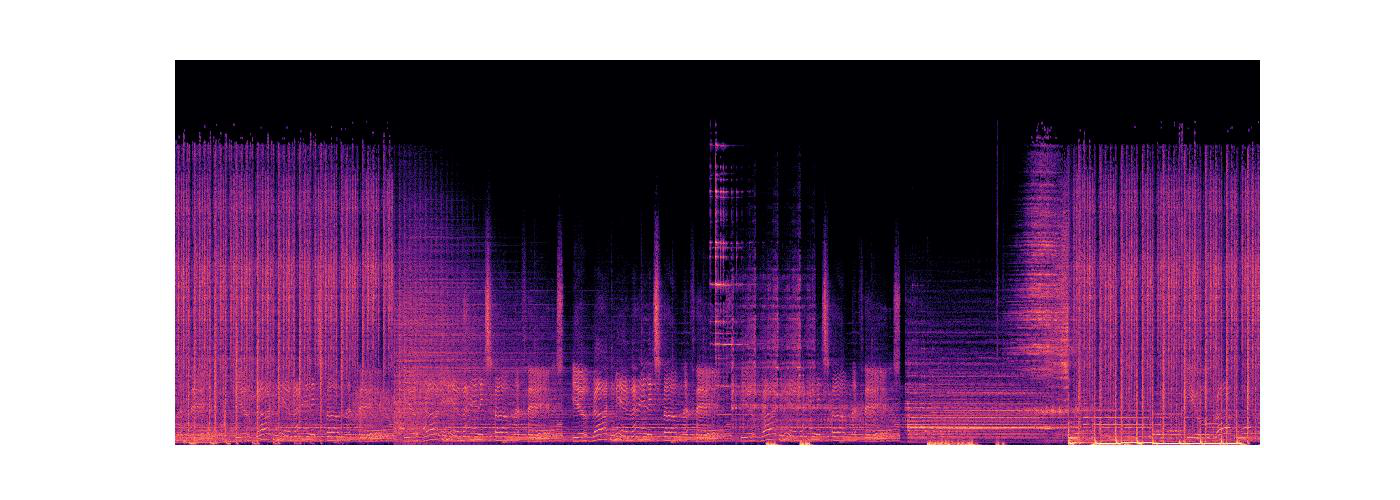

In [11]:
#bad sample 128kbps
bad_smp = Image.open(f'/kaggle/input/spec-dataset-v2/spec_dataset/specs_128/128_{randrange(len(train_bad))}.jpeg')
bad_smp

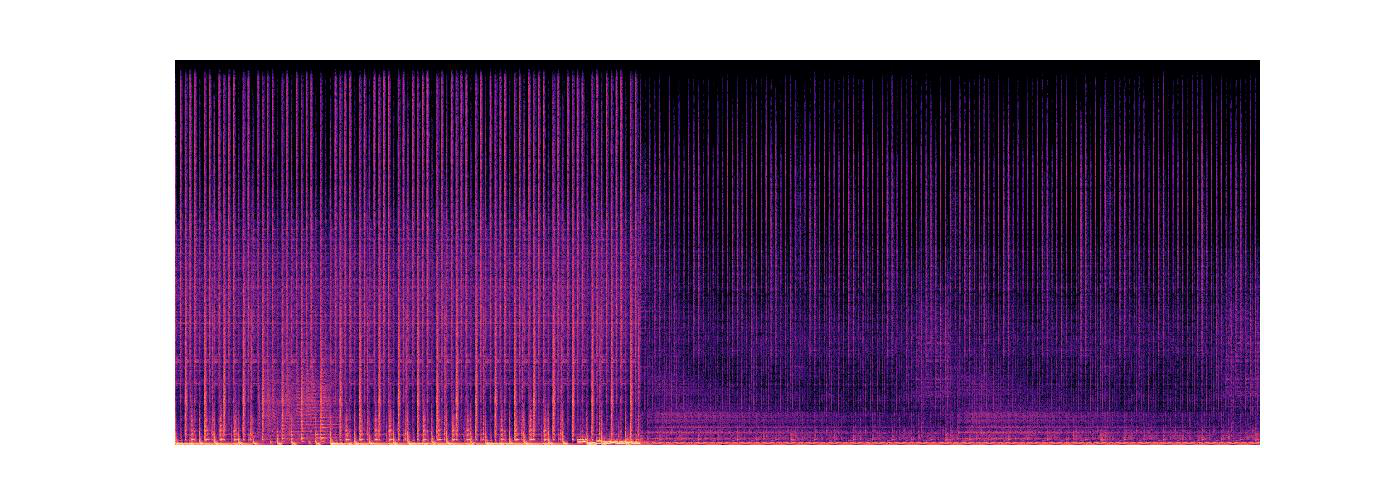

In [12]:
#good sample 320kbps
good_smp = Image.open(f'/kaggle/input/spec-dataset-v2/spec_dataset/specs_320/320_{randrange(len(train_good))}.jpeg')
good_smp

After loading images noticed white borders around them, which needs to be cleaned before continuing so we only have necessary information in the image. All spectograms were generated the same way, so bbox coordinates will fit every single one of them

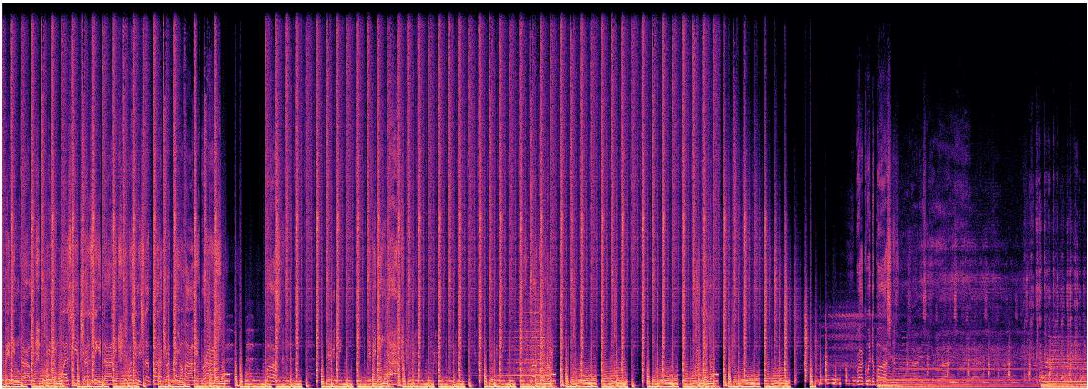

<Figure size 1600x1000 with 0 Axes>

In [13]:
plt.figure(figsize=(16,10))
no_white_img = Image.open(f'/kaggle/input/spec-dataset-v2/spec_dataset/specs_320/320_{randrange(len(train_good))}.jpeg')
no_white_img.crop((173,57,1261,446))

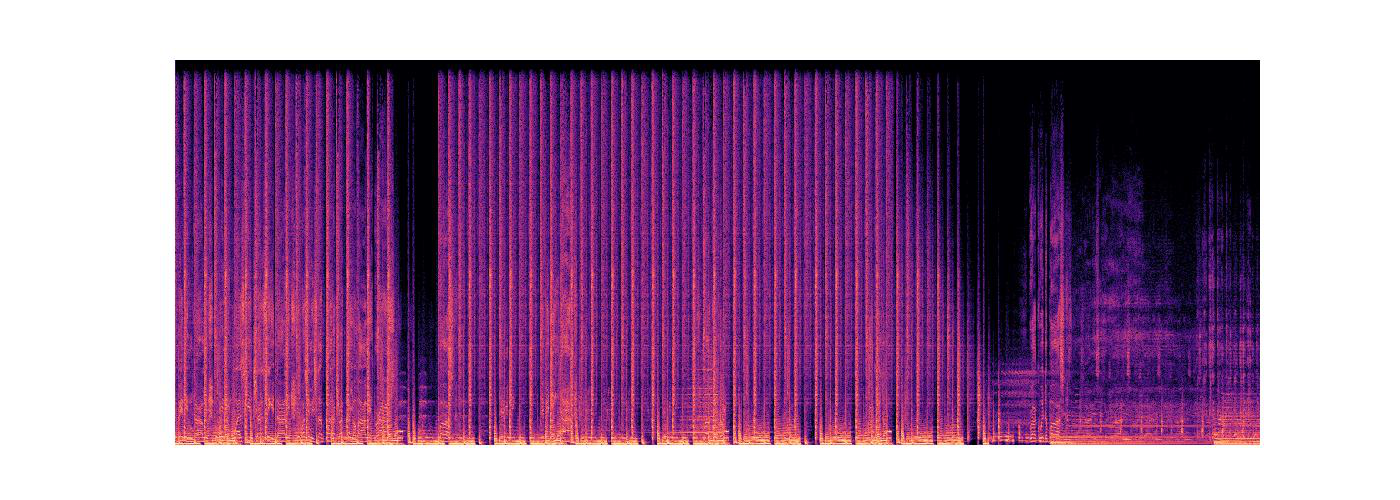

In [14]:
no_white_img

In [15]:
#function to draw a batch of images from df
def draw_batch_imgs(paths ,class_name ,nrows = 2 ,ncols = 2, fsize = (10,6)):
    f, axarr = plt.subplots(nrows ,ncols ,figsize=fsize)

    for i,path in enumerate(paths[:nrows*ncols]):
        img = Image.open(path).crop((173,57,1261,446))
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')
        
    plt.suptitle(class_name, y=0.94)

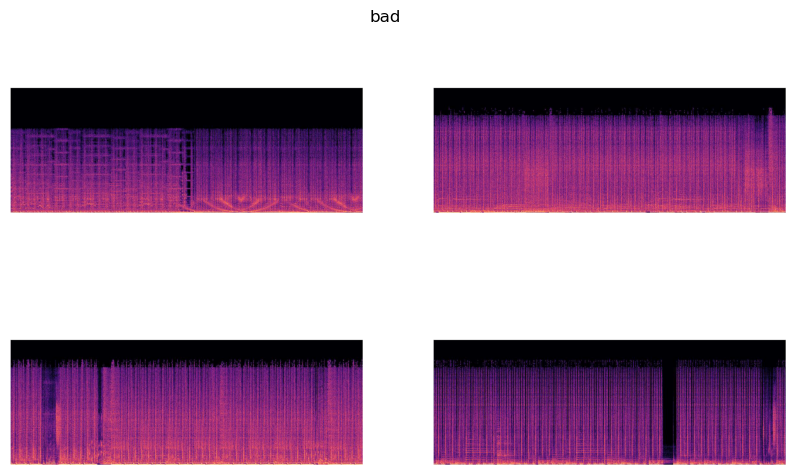

In [16]:
draw_batch_imgs(train_bad['img'],'bad')

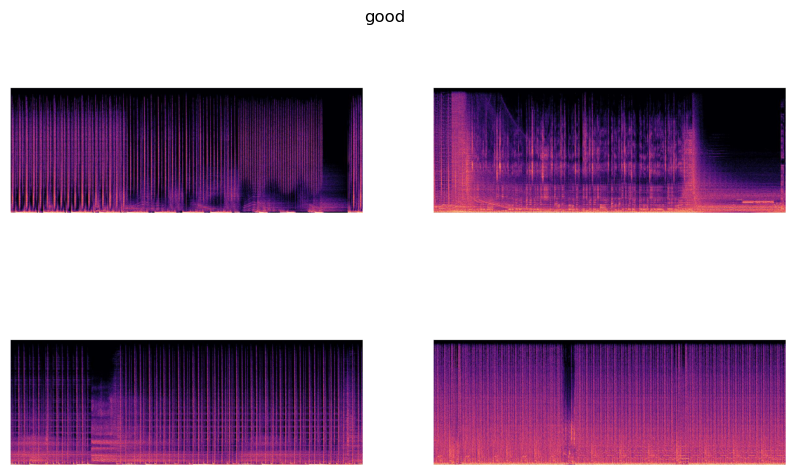

In [17]:
draw_batch_imgs(train_good['img'],'good')

In [18]:
#concatenating both good and bad df into one for dataloader creation
df = pd.concat([train_bad,train_good]).sort_values('img').reset_index(drop=True)
df

img  label
0     /kaggle/input/spec-dataset-v2/spec_dataset/spe...      0
1     /kaggle/input/spec-dataset-v2/spec_dataset/spe...      0
2     /kaggle/input/spec-dataset-v2/spec_dataset/spe...      0
3     /kaggle/input/spec-dataset-v2/spec_dataset/spe...      0
4     /kaggle/input/spec-dataset-v2/spec_dataset/spe...      0
...                                                 ...    ...
5117  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      1
5118  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      1
5119  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      1
5120  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      1
5121  /kaggle/input/spec-dataset-v2/spec_dataset/spe...      1

[5122 rows x 2 columns]

In [19]:
#splitting data into train and valid, for test I will have seperate data to test on
train_df, test_df = train_test_split(df,
                                     stratify=df['label'],
                                     test_size=0.20)
len(train_df),len(test_df)

(4097, 1025)

In [20]:
#dropping indexes so there no issues when calling using generator
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [21]:
class specDataset(Dataset):
    def __init__(self, imgs, labels, transform):
        self.labels = labels
        self.imgs = imgs
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        #cropping out white edges from images
        img = Image.open(self.imgs[idx]).crop((173,57,1261,446))
        img = img.convert("RGB")
        img = self.transform(img)

        return {'img':img,'label':label}

In [22]:
#transforms
preprocess_train = transforms.Compose([
    transforms.Resize(224),
    #the only augmentation seems to be valid for my dataset. 
    #TODO:Want to do more research on Gaussian blur and it out as well
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
preprocess_valid = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
#sanity check that transform works as intended
def plot_transformed_images(df, transform, k=3):
    df_plot = df.sample(n = k)
    for index, row in df_plot.iterrows():
        if row['label'] == 0:
            label = 'bad'
        else:
            label = 'good'
        with Image.open(row['img']) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {label}", fontsize=16)

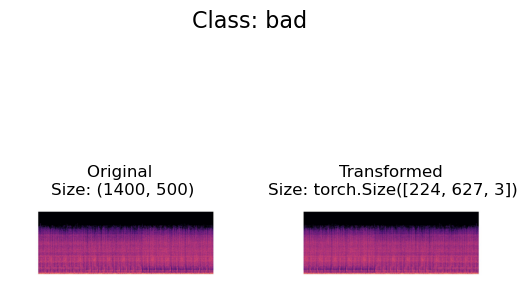

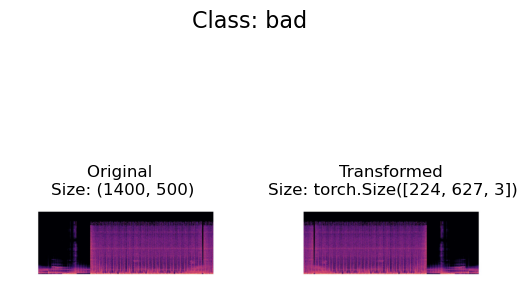

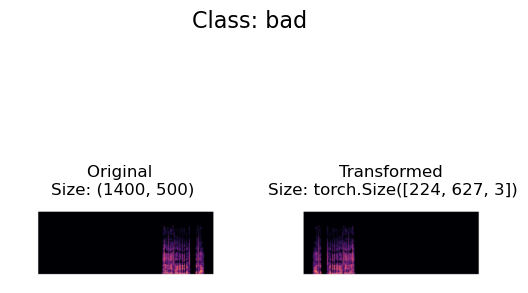

In [24]:
plot_transformed_images(df, transform = preprocess_train, k=3)

In [25]:
#creating datasets
train_ds = specDataset(train_df['img'], train_df['label'], transform = preprocess_train)
valid_ds = specDataset(test_df['img'], test_df['label'], transform = preprocess_valid)

In [26]:
#some variables for training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#loss function of choice BCELoss since I'm working with binary classification problem
lossFunc = nn.BCELoss()

In [27]:
#getting dataloaders ready
train_loader = DataLoader(train_ds,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True if DEVICE == "cuda" else False)
val_loader = DataLoader(valid_ds,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True if DEVICE == "cuda" else False)

<h3>Part 3: Training and Experimenting

In [28]:
#train function
def train_fn(model_to_use, optimizer, loss_fn, dataloader, device):
    model_to_use.train()
    loss_sum = 0
    for data in dataloader:
        optimizer.zero_grad()
        
        inputs, targets = data['img'].to(device), data['label'].to(device).to(torch.float)
        targets = targets.unsqueeze(1)
        
        outputs = model_to_use(inputs)

        loss = loss_fn(outputs, targets)
        loss_sum += loss.item()
        
        loss.backward()
        optimizer.step()
        #scheduler.step()
    
    ep_loss = loss_sum / len(dataloader)
        
    return ep_loss
    

In [29]:
#validation function that calculates accuracy for each class, as well as total and loss
def valid_fn(model_to_use, loss_fn, dataloader, device, classes=('128kbps','320kbps'), threshold=0.5):
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    model_to_use.eval()
    correct = 0
    total = 0
    
    loss_sum = 0
    
    with torch.no_grad():
        for data in dataloader:
            
            inputs, targets = data['img'].to(device), data['label'].to(device).to(torch.float)
            targets = targets.unsqueeze(1)
            
            outputs = model_to_use(inputs)
            
            loss = loss_fn(outputs, targets)
            loss_sum += loss.item()
            
            pred = (outputs > threshold).to(torch.int).to(device)
            
            total += targets.size(0)
            correct += (pred == targets).sum().item()
            
            #acc for each class
            for label, prediction in zip(targets, pred.view(-1)):
                label = label.to(dtype=torch.long, device=device)
                #print(prediction)
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    print(f'Total accuracy: {100 * correct / total} %')
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname} is {accuracy:.1f} %')
    final_loss = loss_sum / len(dataloader)
    return final_loss

I will start with pretty popular CNN architecture ResNet18 without transfer learning that will be my baseline to compare against more modern solutions.<br>
My baseline needs to be good anyway, so I will train for quite a bit and try to find an optimal learning rate as well for my problem.<br>
After that I want to try out a different way to do transfer learning, not just by freezing the last layer but instead use the approach described on medium where was stated that if I have a rather small dataset(4k+ for training) and quite different dataset then I should try to freeze a small amount of layers in the beginning and train the rest of the network, which I want to try out as well.<br>
<br>
Then I want to try out EfficientNet ,ResNext and VGG architectures to compare all of their performace and see how they do and what is the most effective out of all of them for my problem.
<br>My main criterion: quality of the prediction!

In [30]:
model = resnet18(pretrained=False)

modelOutputFeats = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(modelOutputFeats, 1),
                                    nn.Sigmoid())

model = model.to(DEVICE)

print(model)

opt = torch.optim.SGD(model.parameters(), lr=0.001)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
resnet18_train_notl = list()
resnet18_val_notl = list()
best_loss = 10
for epoch in range(35):
    train_loss = train_fn(model, opt, lossFunc, train_loader, DEVICE)
    print(f'Train LOSS = {train_loss}, EPOCH = {epoch}')
    val_loss = valid_fn(model, lossFunc, val_loader, DEVICE)
    if val_loss < best_loss:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":opt.state_dict(),
            'val_loss':val_loss,
            'epoch':epoch
        }
        best_loss = val_loss
    print(f'Validation LOSS = {val_loss}\n')
    resnet18_train_notl.append(np.float32(train_loss))
    resnet18_val_notl.append(np.float32(val_loss))
torch.save(checkpoint, f"/kaggle/working/checkpoint_resnet18_arch.pth.tar")

Train LOSS = 0.5422130938648253, EPOCH = 0
Total accuracy: 91.70731707317073 %
Accuracy for class: 128kbps is 99.8 %
Accuracy for class: 320kbps is 82.6 %
Validation LOSS = 0.3932519085479505

Train LOSS = 0.3147883831068527, EPOCH = 1
Total accuracy: 94.73170731707317 %
Accuracy for class: 128kbps is 100.0 %
Accuracy for class: 320kbps is 88.8 %
Validation LOSS = 0.19053573229096152

Train LOSS = 0.20316553728062978, EPOCH = 2
Total accuracy: 94.82926829268293 %
Accuracy for class: 128kbps is 100.0 %
Accuracy for class: 320kbps is 89.0 %
Validation LOSS = 0.1412647499166655

Train LOSS = 0.14681390837527986, EPOCH = 3
Total accuracy: 96.78048780487805 %
Accuracy for class: 128kbps is 100.0 %
Accuracy for class: 320kbps is 93.2 %
Validation LOSS = 0.10052272745154121

Train LOSS = 0.11209777323890102, EPOCH = 4
Total accuracy: 97.65853658536585 %
Accuracy for class: 128kbps is 100.0 %
Accuracy for class: 320kbps is 95.0 %
Validation LOSS = 0.07177366858178919

Train LOSS = 0.0956227001

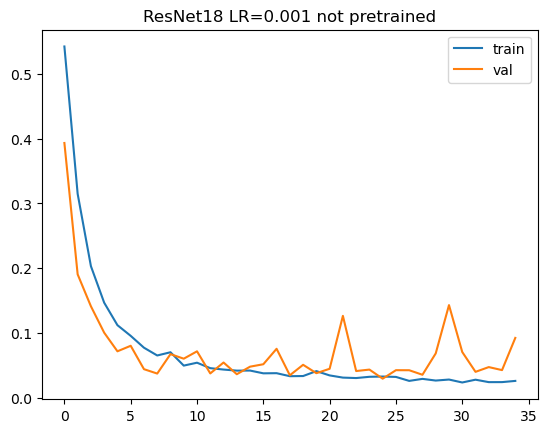

In [32]:
#plot LOSS
plt.plot(resnet18_train_notl,label='train')
plt.plot(resnet18_val_notl,label='val')
plt.legend(['train', 'val'])
plt.title('ResNet18 LR=0.001 not pretrained')
plt.show()

In [33]:
checkpoint['epoch'], checkpoint['val_loss']

(24, 0.02953322458250279)

The results that resnet18 were able to achieve pretty impressive and unexpected. Saved the best model based on best validation loss and Want to try and compare resnet18 not pretrained with the pretrained one on transfer learning with different size of the model being available to train

<h3>Part 4: Transfer Learning

<h3>ResNet18 pretrained with last layer unfrozen, no normalization

In [83]:
model = resnet18(pretrained=True)


#freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

#resetting last layer and making output fit needs of this dataset
modelOutputFeats = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(modelOutputFeats, 1),
                                    nn.Sigmoid())
model = model.to(DEVICE)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
opt = torch.optim.SGD(model.parameters(), lr=0.001)
#batch size 32 and ResNet18, lr = 0.001
resnet18_pre_train = list()
resnet18_pre_val = list()
for epoch in range(10):
    train_loss = train_fn(model, opt, lossFunc, train_loader, DEVICE)
    print(f'Train LOSS = {train_loss}, EPOCH = {epoch}')
    val_loss = valid_fn(model, lossFunc, val_loader, DEVICE)
    print(f'Validation LOSS = {val_loss}\n')
    resnet18_pre_train.append(np.float32(train_loss))
    resnet18_pre_val.append(np.float32(val_loss))

Train LOSS = 0.600627834020659, EPOCH = 0
Total accuracy: 75.60975609756098 %
Accuracy for class: 128kbps is 92.4 %
Accuracy for class: 320kbps is 56.8 %
Validation LOSS = 0.5575411906748107

Train LOSS = 0.5049158884573353, EPOCH = 1
Total accuracy: 86.14634146341463 %
Accuracy for class: 128kbps is 93.2 %
Accuracy for class: 320kbps is 78.3 %
Validation LOSS = 0.4952601980079304

Train LOSS = 0.443193352961725, EPOCH = 2
Total accuracy: 90.14634146341463 %
Accuracy for class: 128kbps is 86.3 %
Accuracy for class: 320kbps is 94.4 %
Validation LOSS = 0.4244911733901862

Train LOSS = 0.39314258560653803, EPOCH = 3
Total accuracy: 91.41463414634147 %
Accuracy for class: 128kbps is 87.8 %
Accuracy for class: 320kbps is 95.5 %
Validation LOSS = 0.38653411558180145

Train LOSS = 0.3568923981614815, EPOCH = 4
Total accuracy: 93.85365853658537 %
Accuracy for class: 128kbps is 94.8 %
Accuracy for class: 320kbps is 92.8 %
Validation LOSS = 0.3450517844070088

Train LOSS = 0.32550785453744635, E

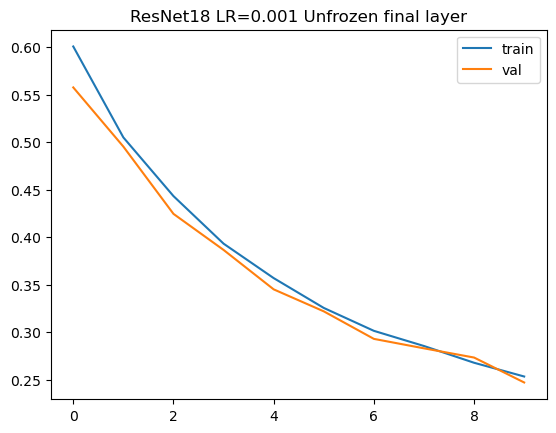

In [30]:
#plot LOSS
plt.plot(resnet18_pre_train,label='train')
plt.plot(resnet18_pre_val,label='val')
plt.legend(['train', 'val'])
plt.title('ResNet18 LR=0.001 Unfrozen final layer')
plt.show()

<h3>ResNet18 pretrained with last layer unfrozen, with normalization

In [84]:
opt = torch.optim.SGD(model.parameters(), lr=0.001)
#batch size 32 and ResNet18, lr = 0.001 BUT with Normalization on ImageNet
rn18_pre_train_norm = list()
rn18_pre_val_norm = list()
for epoch in range(10):
    train_loss = train_fn(model, opt, lossFunc, train_loader, DEVICE)
    print(f'Train LOSS = {train_loss}, EPOCH = {epoch}')
    val_loss = valid_fn(model, lossFunc, val_loader, DEVICE)
    print(f'Validation LOSS = {val_loss}\n')
    rn18_pre_train_norm.append(np.float32(train_loss))
    rn18_pre_val_norm.append(np.float32(val_loss))

Train LOSS = 0.5789646982222565, EPOCH = 0
Total accuracy: 82.63414634146342 %
Accuracy for class: 128kbps is 99.6 %
Accuracy for class: 320kbps is 63.6 %
Validation LOSS = 0.5073898759755221

Train LOSS = 0.4833789398503858, EPOCH = 1
Total accuracy: 94.04878048780488 %
Accuracy for class: 128kbps is 93.2 %
Accuracy for class: 320kbps is 95.0 %
Validation LOSS = 0.4352025660601529

Train LOSS = 0.4198145226452702, EPOCH = 2
Total accuracy: 92.48780487804878 %
Accuracy for class: 128kbps is 99.6 %
Accuracy for class: 320kbps is 84.5 %
Validation LOSS = 0.38584055683829566

Train LOSS = 0.37097648433012553, EPOCH = 3
Total accuracy: 96.39024390243902 %
Accuracy for class: 128kbps is 95.4 %
Accuracy for class: 320kbps is 97.5 %
Validation LOSS = 0.3457178807619846

Train LOSS = 0.33625647310138673, EPOCH = 4
Total accuracy: 95.51219512195122 %
Accuracy for class: 128kbps is 98.5 %
Accuracy for class: 320kbps is 92.1 %
Validation LOSS = 0.3126859308192224

Train LOSS = 0.3088013175152993,

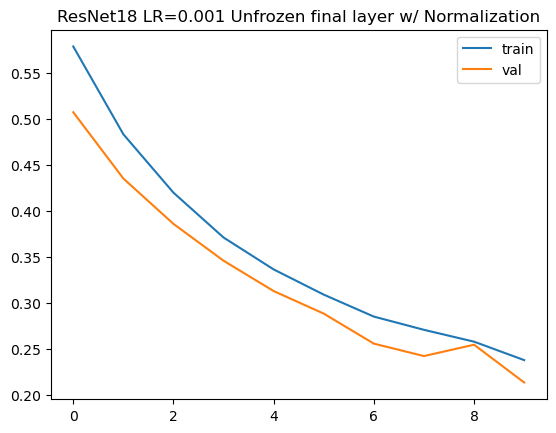

In [85]:
#plot LOSS
plt.plot(rn18_pre_train_norm,label='train')
plt.plot(rn18_pre_val_norm,label='val')
plt.legend(['train', 'val'])
plt.title('ResNet18 LR=0.001 Unfrozen final layer w/ Normalization')
plt.show()

<h3>Unfrozen 60 percent of the model for training

In [27]:
model = resnet18(pretrained=True)

#first part/child of the model - 'features' is half frozen and the rest of layers are unfrozen for training
best_loss = 10
ct = 0
for child  in model.children():
    ct+=1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False
            
modelOutputFeats = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(modelOutputFeats, 1),
                                    nn.Sigmoid())
model = model.to(DEVICE)

opt = torch.optim.SGD(model.parameters(), lr=0.001)

rn18_half_tr = list()
rn18_half_val = list()
for epoch in range(35):
    train_loss = train_fn(model, opt, lossFunc, train_loader, DEVICE)
    print(f'Train LOSS = {train_loss}, EPOCH = {epoch}')
    val_loss = valid_fn(model, lossFunc, val_loader, DEVICE)
    if val_loss < best_loss:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":opt.state_dict(),
            'val_loss':val_loss,
            'epoch':epoch
        }
        best_loss = val_loss
    print(f'Validation LOSS = {val_loss}\n')
    rn18_half_tr.append(np.float32(train_loss))
    rn18_half_val.append(np.float32(val_loss))
torch.save(checkpoint, f"/kaggle/working/checkpoint_resnet18_pre.pth.tar")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train LOSS = 0.4504066839698673, EPOCH = 0
Total accuracy: 97.5609756097561 %
Accuracy for class: 128kbps is 98.7 %
Accuracy for class: 320kbps is 96.3 %
Validation LOSS = 0.22518660173271643

Train LOSS = 0.18211305384026016, EPOCH = 1
Total accuracy: 98.82926829268293 %
Accuracy for class: 128kbps is 99.3 %
Accuracy for class: 320kbps is 98.3 %
Validation LOSS = 0.10680401246204521

Train LOSS = 0.10436409209356752, EPOCH = 2
Total accuracy: 99.21951219512195 %
Accuracy for class: 128kbps is 99.1 %
Accuracy for class: 320kbps is 99.4 %
Validation LOSS = 0.06996698892026236

Train LOSS = 0.07738039925578953, EPOCH = 3
Total accuracy: 99.41463414634147 %
Accuracy for class: 128kbps is 99.1 %
Accuracy for class: 320kbps is 99.8 %
Validation LOSS = 0.05042393832947269

Train LOSS = 0.0674015701452429, EPOCH = 4
Total accuracy: 98.92682926829268 %
Accuracy for class: 128kbps is 99.8 %
Accuracy for class: 320kbps is 97.9 %
Validation LOSS = 0.04421098571919808

Train LOSS = 0.0553266207377

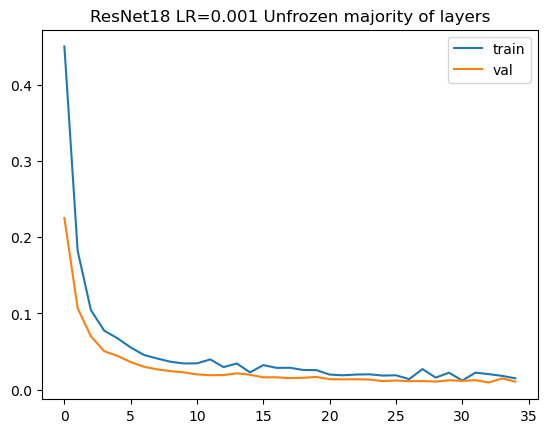

In [28]:
#plot LOSS
plt.plot(rn18_half_tr,label='train')
plt.plot(rn18_half_val,label='val')
plt.legend(['train', 'val'])
plt.title('ResNet18 LR=0.001 Unfrozen majority of layers')
plt.show()

In [29]:
checkpoint['epoch'], checkpoint['val_loss']

(32, 0.009346822580096848)

First of all ResNet18 in general did a good job in recognizing pattern for categorizing music spectograms into good(320kbps) and bad(128kbps) quality ones, but pushing the performance even further and trying ResNet18 with pretrained weights was a great idea but for it to work I had to unfreeze more layers to overcome results of training the whole ResNet18 without pretrained weights. Ended up with perfrect results and ready for test stage and implementation into a small software using PySimpleGUI for more hands on practice with Python.
<br>
<br>
After testing and observing results as well as probabilities I decided to use the model that utilized transfer learning, it was way more confident about it decisions and overall more accurate